# <h1><center>Quality Diversity Tutorial</center></h1>

This notebook provides an introductory tutorial to Quality Diversity algorithms. Specifically, we will apply MAP-Elites to acquire a diverse set of locomotion behaviours for a simplified brittle star robot. The [brittle star robot and its environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star) is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). Instead of directly evolving joint-level actions, we will evolve modulation parameters for a Central Pattern Generator, that in turn outputs the joint-level actions.

## Quality Diversity algorithms

### MAP-Elites

In [24]:
from functools import partial
import chex
import tqdm
from flax import struct
import jax.numpy as jnp
import jax
from typing import Tuple, Type


@struct.dataclass
class MAPElitesState:
    parameter_archive: jnp.ndarray
    fitness_archive: jnp.ndarray
    filled: jnp.ndarray


class MAPElites:
    def __init__(
            self,
            dimensions: Tuple[int, ...],
            num_parameters: int,
            noise_scale: float,
            descriptor_low: jnp.ndarray,
            descriptor_high: jnp.ndarray,
            parameters_low: jnp.ndarray,
            parameters_high: jnp.ndarray
            ) -> None:
        self._dimensions = dimensions
        self._num_parameters = num_parameters
        self._noise_scale = noise_scale
        self._descriptor_low = descriptor_low
        self._descriptor_high = descriptor_high
        self._parameters_low = parameters_low
        self._parameters_high = parameters_high

    @partial(jax.jit, static_argnums=(0,))
    def select_random_parameters(
            self,
            rng: chex.PRNGKey,
            state: MAPElitesState
            ) -> jnp.ndarray:
        """
        Returns a random cell's parameters
        """
        cell_index = jax.random.randint(
                key=rng,
                shape=(len(self._dimensions),),
                minval=jnp.zeros(len(self._dimensions)),
                maxval=jnp.array(self._dimensions)
                )
        parameters = state.parameter_archive[*cell_index]
        return parameters

    @partial(jax.jit, static_argnums=(0,))
    def mutate_parameters(
            self,
            rng: chex.PRNGKey,
            parameters: jnp.ndarray
            ) -> jnp.ndarray:
        noise = jax.random.normal(key=rng, shape=(len(parameters),)) * self._noise_scale
        parameters = parameters + noise
        parameters = jnp.clip(a=parameters, a_min=self._parameters_low, a_max=self._parameters_high)
        return parameters

    @partial(jax.jit, static_argnums=(0,))
    def _get_cell_index(
            self,
            descriptor: jnp.ndarray
            ) -> Tuple[int, ...]:
        descriptor = jnp.clip(a=descriptor, a_min=self._descriptor_low, a_max=self._descriptor_high)

        # Renormalize descriptor to [0, 1] range
        descriptor = (descriptor - self._descriptor_low) / (self._descriptor_high - self._descriptor_low)
        cell_index = (descriptor * jnp.array(self._dimensions)).astype(jnp.int32)
        return cell_index

    @partial(jax.jit, static_argnums=(0,))
    def add_to_archive(
            self,
            state: MAPElitesState,
            descriptor: jnp.ndarray,
            fitness: float,
            parameters: jnp.ndarray
            ) -> MAPElitesState:
        cell_index = self._get_cell_index(descriptor=descriptor)

        pred = ~state.filled[*cell_index] | (fitness > state.fitness_archive[*cell_index])

        def _replace() -> MAPElitesState:
            # noinspection PyUnresolvedReferences
            return state.replace(
                    parameter_archive=state.parameter_archive.at[*cell_index].set(parameters),
                    fitness_archive=state.fitness_archive.at[*cell_index].set(fitness),
                    filled=state.filled.at[*cell_index].set(True)
                    )

        def _do_not_replace() -> MAPElitesState:
            return state

        return jax.lax.cond(
                pred, _replace, _do_not_replace
                )

    @partial(jax.jit, static_argnums=(0,))
    def reset(
            self,
            rng: chex.PRNGKey
            ) -> MAPElitesState:
        # noinspection PyArgumentList
        return MAPElitesState(
                parameter_archive=jax.random.uniform(
                        key=rng,
                        shape=self._dimensions + (len(self._parameters_low),),
                        dtype=jnp.float32,
                        minval=self._parameters_low,
                        maxval=self._parameters_high
                        ), fitness_archive=-jnp.inf * jnp.ones(self._dimensions), filled=jnp.zeros(self._dimensions).astype(bool)
                )

## Case study: CPG modulations for brittle star locomotion

### Modulation parameters

* No coupling between oscillators of different arms
* 2 oscillators per arm (one in plane, one out-of-plane)
    * all segments of arm share these outputs
* Parameters
    * 1 common frequency
    * Per arm: 2 oscillators:
        * Per oscillator amplitude, offset
        * phase bias for coupling 

* 5 armed brittle star, 3 segments per arm, arm segments behave the same -> 2 oscillators per arm -> 10 oscillators in total -> 30 parameters (oscillator ones) + 1 (common frequency)

### Environment setup

In [25]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Thu Feb  1 20:53:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   53C    P0              20W /  60W |  11553MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
from brb.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from brb.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration
import numpy as np
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from typing import List
import mediapy as media
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=3, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 10), sand_ground_color=False, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )


def create_environment() -> BrittleStarUndirectedLocomotionEnvironment:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarUndirectedLocomotionEnvironment.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend="MJX"
            )
    return env


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None],
        path: str | None = None
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(
                f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379)."
                )
    if path:
        media.write_video(path=path, images=filtered_images)
    return media.show_video(images=filtered_images)

In [27]:
rng = jax.random.PRNGKey(seed=0)
env = create_environment()
env_reset_fn = jax.jit(env.reset)
env_step_fn = jax.jit(env.step)

Observation space:
Dict('joint_position': Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (15,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>))

Action space:
Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>)


""

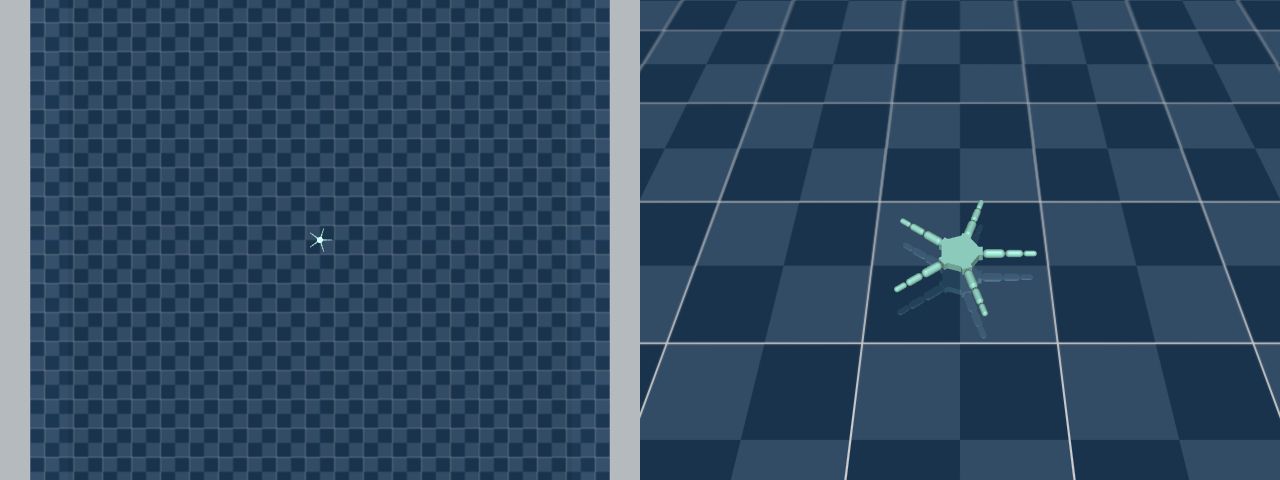

In [28]:
print("Observation space:")
print(env.observation_space)
print()
print("Action space:")
print(env.action_space)
rng, sub_rng = jax.random.split(rng, 2)
env_state = env_reset_fn(rng=sub_rng)
media.show_image(post_render(env.render(env_state), environment_configuration=env.environment_configuration))

### CPG Setup
* Same as in CPG tutorial, but no couplings between oscillators

In [29]:
import functools
from flax import struct
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Tuple

from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

    # We'll make these modulatory parameters part of the state as they will change as well
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


class CPG:
    def __init__(
            self,
            weights: jnp.ndarray,
            amplitude_gain: float = 20,
            offset_gain: float = 20,
            dt: float = 0.01, ) -> None:
        self._weights = weights
        self._amplitude_gain = amplitude_gain
        self._offset_gain = offset_gain
        self._dt = dt
        self._solver = euler_solver

    @property
    def num_oscillators(
            self
            ) -> int:
        return self._weights.shape[0]

    @staticmethod
    def phase_de(
            weights: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray,
            phase_biases: jnp.ndarray,
            omegas: jnp.ndarray
            ) -> jnp.ndarray:
        @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
        def sine_term(
                phase_i: float,
                phase_biases_i: float
                ) -> jnp.ndarray:
            return jnp.sin(phases - phase_i - phase_biases_i)

        couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
        return omegas + couplings

    @staticmethod
    def second_order_de(
            gain: jnp.ndarray,
            modulator: jnp.ndarray,
            values: jnp.ndarray,
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return gain * ((gain / 4) * (modulator - values) - dot_values)

    @staticmethod
    def first_order_de(
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return dot_values

    @staticmethod
    def output(
            offsets: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray
            ) -> jnp.ndarray:
        return offsets + amplitudes * jnp.cos(phases)

    def reset(
            self,
            rng: chex.PRNGKey
            ) -> CPGState:
        phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
        # noinspection PyArgumentList
        state = CPGState(
                phases=jax.random.uniform(
                        key=phase_rng, shape=(self.num_oscillators,), dtype=jnp.float32, minval=-0.01, maxval=0.01
                        ),
                amplitudes=jnp.zeros(self.num_oscillators),
                offsets=jnp.zeros(self.num_oscillators),
                dot_amplitudes=jnp.zeros(self.num_oscillators),
                dot_offsets=jnp.zeros(self.num_oscillators),
                outputs=jnp.zeros(self.num_oscillators),
                time=0.0,
                R=jnp.zeros(self.num_oscillators),
                X=jnp.zeros(self.num_oscillators),
                omegas=jnp.zeros(self.num_oscillators),
                rhos=jnp.zeros_like(self._weights)
                )
        return state

    @functools.partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: CPGState
            ) -> CPGState:
        # Update phase
        new_phases = self._solver(
                current_time=state.time,
                y=state.phases,
                derivative_fn=lambda
                    t,
                    y: self.phase_de(
                        omegas=state.omegas,
                        amplitudes=state.amplitudes,
                        phases=y,
                        phase_biases=state.rhos,
                        weights=self._weights
                        ),
                delta_time=self._dt
                )
        new_dot_amplitudes = self._solver(
                current_time=state.time,
                y=state.dot_amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._amplitude_gain, modulator=state.R, values=state.amplitudes, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_amplitudes = self._solver(
                current_time=state.time,
                y=state.amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_amplitudes),
                delta_time=self._dt
                )
        new_dot_offsets = self._solver(
                current_time=state.time,
                y=state.dot_offsets,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._offset_gain, modulator=state.X, values=state.offsets, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_offsets = self._solver(
                current_time=0,
                y=state.offsets,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_offsets),
                delta_time=self._dt
                )

        new_outputs = self.output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
        # noinspection PyUnresolvedReferences
        return state.replace(
                phases=new_phases,
                dot_amplitudes=new_dot_amplitudes,
                amplitudes=new_amplitudes,
                dot_offsets=new_dot_offsets,
                offsets=new_offsets,
                outputs=new_outputs,
                time=state.time + self._dt
                )


def create_cpg() -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))

    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, ip_oscillator_indices].set(1)

    return CPG(
            weights=5 * adjacency_matrix,
            amplitude_gain=20,
            offset_gain=20,
            dt=environment_configuration.control_timestep
            )

@jax.jit
def map_cpg_outputs_to_actions(
        cpg_state: CPGState
        ) -> jnp.ndarray:
    num_arms = morphology_specification.number_of_arms
    num_oscillators_per_arm = 2
    num_segments_per_arm = morphology_specification.number_of_segments_per_arm[0]

    cpg_outputs_per_arm = cpg_state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

### Behaviour descriptor and fitness
* Behaviour: Final XY position
* Fitness: energy efficiency 

### Evaluation function
* input: parameters (i.e. modulation parameters)
* output: fitness, behaviour description

In [30]:
def modulate_cpg(
        cpg_state: CPGState,
        parameters: jnp.ndarray
        ) -> CPGState:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    R = parameters[:10]
    X = parameters[10: 20]
    omega = parameters[21]
    phase_biases = parameters[21:]

    # phase biases is a list of 5 elements, which denote the phase bias between the IP and OOP oscillator of every arm
    rhos = cpg_state.rhos.at[ip_oscillator_indices, oop_oscillator_indices].set(phase_biases)
    rhos = rhos.at[oop_oscillator_indices, ip_oscillator_indices].set(-phase_biases)
    # noinspection PyUnresolvedReferences
    return cpg_state.replace(
            R=R, X=X, omegas=jnp.ones_like(cpg_state.omegas) * omega, rhos=rhos
            )

In [31]:
from mujoco_utils.environment.mjx_env import MJXEnvState
from typing import Any, Dict


@partial(jax.jit, static_argnums=(0,))
def evaluate_parameters(
        cpg: CPG,
        rng: chex.PRNGKey,
        modulation_parameters: jnp.ndarray
        ) -> Tuple[float, jnp.ndarray]:
    env_rng, cpg_rng = jax.random.split(rng, 2)
    env_state = env_reset_fn(rng=env_rng)
    cpg_state = cpg.reset(rng=cpg_rng)

    cpg_state = modulate_cpg(cpg_state=cpg_state, parameters=modulation_parameters)

    def _take_step(
            _state: Tuple[MJXEnvState, CPGState],
            _: None
            ) -> Tuple[Tuple[MJXEnvState, CPGState], Dict[str, Any]]:
        _env_state, _cpg_state = _state

        actions = map_cpg_outputs_to_actions(cpg_state=_cpg_state)
        actions = jnp.clip(a=actions, a_min=env.action_space.low, a_max=env.action_space.high)

        _next_env_state = env_step_fn(state=_env_state, action=actions)
        _next_cpg_state = cpg.step(state=_cpg_state)

        carry = (_next_env_state, _next_cpg_state)
        return carry, jnp.average(jnp.abs(_env_state.observations["joint_actuator_force"]))

    carry, scan_out = jax.lax.scan(
            _take_step, (env_state, cpg_state), (), env.environment_configuration.total_num_control_steps
            )

    # fitness: -average amount of energy used (we negate because we maximise fitness)
    fitness = -jnp.average(scan_out)

    # Descriptor: final XY position
    descriptor = carry[0].observations["disk_position"][:2]

    return fitness, descriptor

### Optimization

In [32]:
@partial(jax.jit, static_argnums=(0, 1))
def MAP_elites_iteration(
        map_elites: MAPElites,
        cpg: CPG,
        map_elites_state: MAPElitesState,
        rng: chex.PRNGKey
        ) -> MAPElitesState:
    selection_rng, mutation_rng, evaluation_rng = jax.random.split(key=rng, num=3)

    parameters = map_elites.select_random_parameters(rng=selection_rng, state=map_elites_state)
    parameters = map_elites.mutate_parameters(rng=mutation_rng, parameters=parameters)

    fitness, descriptor = evaluate_parameters(cpg=cpg, rng=evaluation_rng, modulation_parameters=parameters)

    map_elites_state = map_elites.add_to_archive(
            state=map_elites_state, fitness=fitness, descriptor=descriptor, parameters=parameters
            )

    return map_elites_state

In [33]:
parameters_low = jnp.concatenate(
        (jnp.zeros(10), -jnp.ones(10), jnp.zeros(1), -jnp.pi * jnp.ones(5))
        )
parameters_high = jnp.concatenate(
        (jnp.ones(10), jnp.ones(10), 3 * jnp.pi * jnp.ones(1), jnp.pi * jnp.ones(5))
        )

map_elites = MAPElites(
        dimensions=(30, 30),
        num_parameters=31,
        noise_scale=0.1,
        descriptor_low=-5 * jnp.ones(2),
        descriptor_high=5 * jnp.ones(2),
        parameters_low=parameters_low,
        parameters_high=parameters_high
        )
cpg = create_cpg()

rng = jax.random.PRNGKey(seed=0)
rng, reset_rng = jax.random.split(rng, 2)
map_elites_state = map_elites.reset(rng=reset_rng)

In [34]:
rng, iteration_rng = jax.random.split(rng, 2)
map_elites_state = MAP_elites_iteration(
        map_elites=map_elites, cpg=cpg, map_elites_state=map_elites_state, rng=iteration_rng
        )

Vectorization

In [35]:
vectorized_iteration = jax.jit(jax.vmap(MAP_elites_iteration, in_axes=(None, None, None, 0)), static_argnums=(0, 1))

In [36]:
num_parallel_evaluations = 2
rng, *sub_rngs = jax.random.split(key=rng, num=num_parallel_evaluations + 1)
map_elites_states = vectorized_iteration(map_elites, cpg, map_elites_state, jnp.array(sub_rngs))

In [37]:
@jax.jit
def merge_map_elite_states(
        states: MAPElitesState
        ) -> MAPElitesState:
    filled = jnp.max(states.filled, axis=0)

    fitness_archive = jnp.max(states.fitness_archive, axis=0)

    # Keep the parameters corresponding to the best fitness values
    state_indices_of_highest_fitnesses = jnp.argmax(states.fitness_archive, axis=0)
    parameter_archive = states.parameter_archive[
        state_indices_of_highest_fitnesses, jnp.arange(states.parameter_archive.shape[1])[:, None], jnp.arange(
                states.parameter_archive.shape[2]
                )]

    # noinspection PyArgumentList
    return MAPElitesState(
            filled=filled, fitness_archive=fitness_archive, parameter_archive=parameter_archive
            )



In [38]:
rng, reset_rng = jax.random.split(rng, 2)
map_elites_state = map_elites.reset(rng=reset_rng)

num_parallel_evaluations = 128
num_iterations = 300

In [ ]:
for _ in tqdm.tqdm(range(num_iterations), desc="Filling archive"):
    rng, *sub_rngs = jax.random.split(key=rng, num=num_parallel_evaluations + 1)
    map_elites_states = vectorized_iteration(map_elites, cpg, map_elites_state, jnp.array(sub_rngs))
    map_elites_state = merge_map_elite_states(map_elites_states)

Filling archive:  12%|█▏        | 35/300 [05:10<34:49,  7.88s/it] 

Logging -> every 10 generations:
- Average, min, max fitness
- Num filled, abs and relative
- Archive visualization

### Result evaluation

todo: Visualize some cells

## Next steps
* Try to do this for non-shared oscillators per arm segments -> more complex behaviours possible
* Incorporate cross-over
* use https://github.com/adaptive-intelligent-robotics/QDax
* Incorporate our prior knowledge on brittle star behaviour -> leading arm + rowers -> we can share parameters between rowers on same side / invert the in-plane motion for left and right rowers
    * Do this for forward locomotion only -> changing direction is just changing roles of arms
    * fitness: energy efficiency
    * behaviour: find a nice way to describe a rowing motion (could be a dimensionality reduction technique applied to our modulation parameters)
- E.g. multi level
    - Bottom level → segment groups
    - Middle level → arm (combines N-SEGMENTS bottom level ones)
    - Top level → body (combines N-ARMS middle level ones)
        - Descriptor : should promote a diverse group of behaviours
        - Quality: top level should do well (e.g. BD: final XY position, F: energy efficiency / disk stability / ...) → fitness is propagated to lower levels

## Reading material

* Quality diversity review
* CVT-MAP-Elites
* Multi level ME
